---
title: "Docker notes"
description: "Docker notes"
date: 2024-09
categories: [Programming]
---

- Containers are isolated environments using the kernel of your host OS
    - They are running instances of images which are "blueprints" or snapshots for containers
    - They are build in layers, which can be used across multiple images
- Images ~ Classes: Specified via Dockerfile
- Containers ~ Objects: instantiations of images
- Dockerfile: Text document containing commands user would call on the command line to assemble an image



- Basic Dockerfile launching a shell with Python 3.8 available:

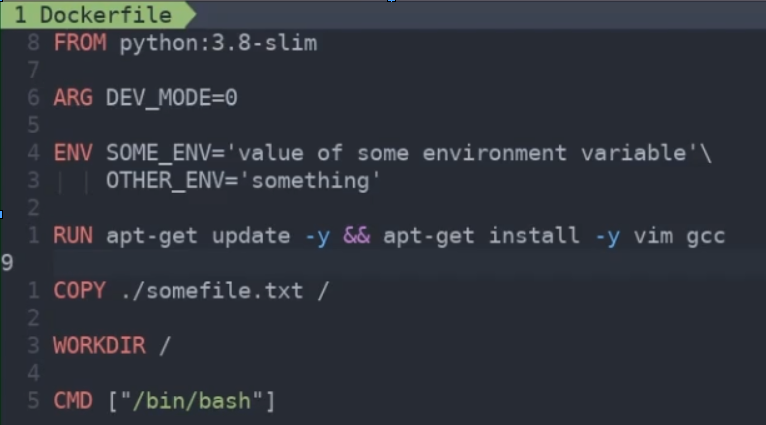

- Anything below a changed line runs so it’s important to specify frequently-changing commands at the bottom of the file, non frequently used at the top.  Reduces Docker runtime
- Each command creates a new layer.  Keeping the number of layers as low as possible will keep image size down -> Use \ as shown above for ENV + double-and for RUN + follow install with multiple things to install


- Dockerfile definitions:

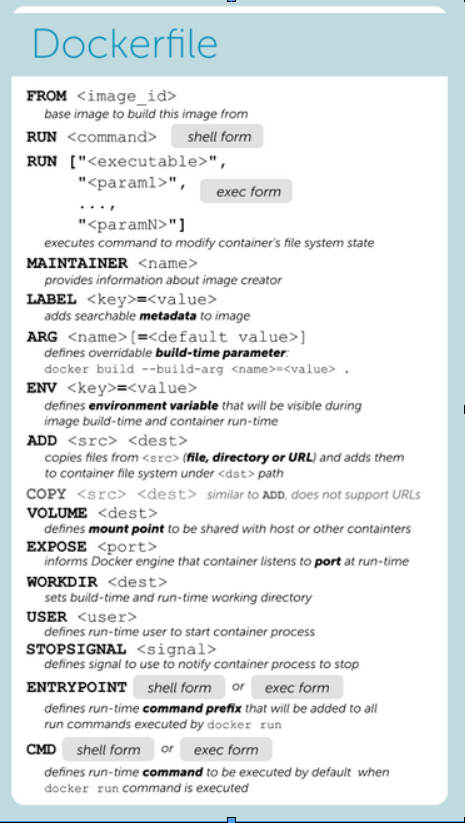

## Docker ABCs: Running a simple application with Docker volume to persist data

- Step 1: Create Dockerfile

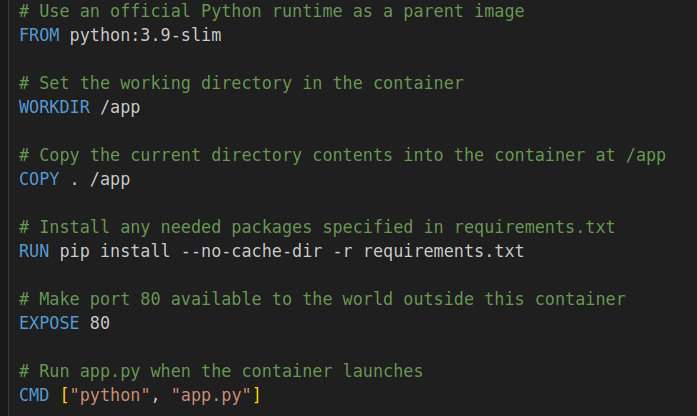

- Step 2: Create simple Python application

In [ ]:
# app.py
import os
import time

# Create a file and write some content to it
with open("output.txt", "a") as f:
    f.write(f"Hello from Docker!\nTime: {time.time()}\n")

print("File written successfully.")

- Step 3: Create requirements.txt to specify Python dependencies.

- Step 4: Build the Docker image using Dockerfile and name it (here my-python-app)

In [ ]:
%%bash
docker build -t my-python-app .

- Step 5: Run the Docker image with a volume

In [ ]:
%%bash
docker run -v $(pwd):/app my-python-app

- Can also run interactively and run from shell from inside a container:
    - When run the container, application will write message + time
    - Can run `python app.py` from inside the container, which will keep appending to the file
    - `exit` and the changes will persist

In [ ]:
%%bash
docker run -it --name my-python-app-container -v $(pwd):/app my-python-app /bin/bash

- Don't forget to remove the container with `docker rm my-python-app-container`, or better yet, run with rm flag as below:

In [ ]:
%%bash
docker run --rm -it --name my-python-app-container -v $(pwd):/app my-python-app /bin/bash

## Following Learn Docker in a Month of Lunches by Elton Stoneman

### Ch.2: Understanding Docker and Hello World

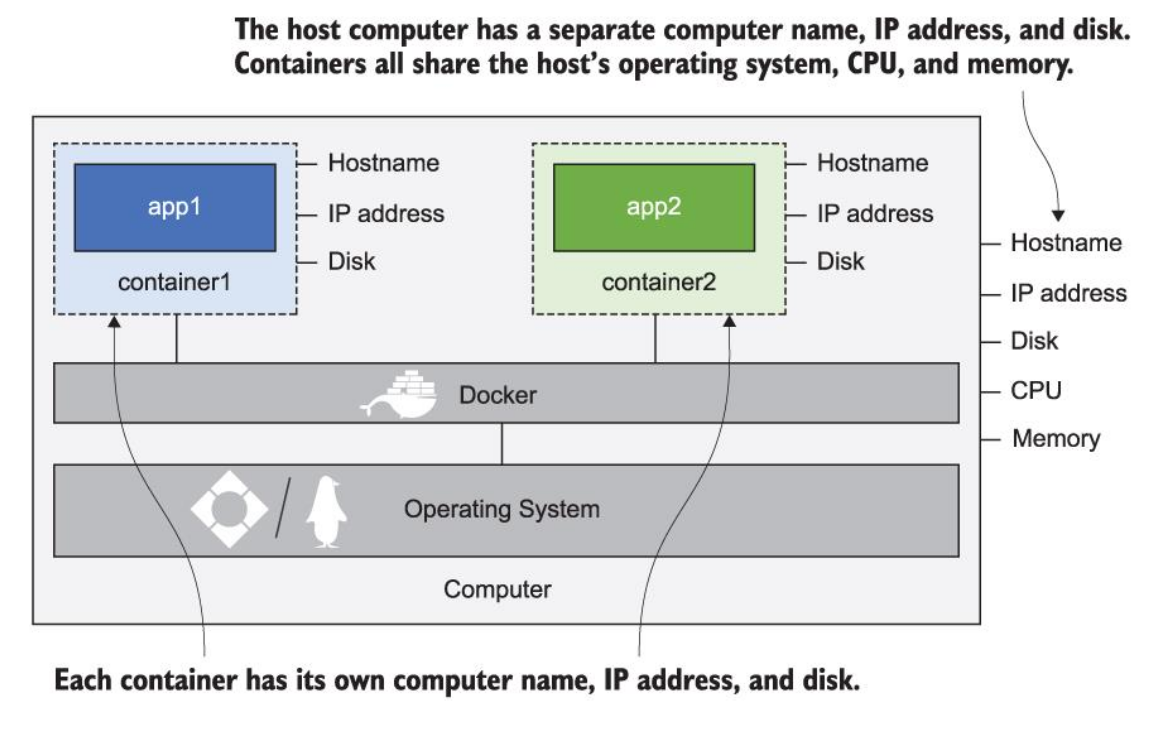

- Note that each container shares the operating system of the host computer!

- `docker container ls`: lists running containers; add --all to see exited containers
- `docker container logs {start_of_container_id}`: displays log entries collected by container
- `docker container stats {start_of_container_id}`: displays stats about CPU, memory, network, and disk the container is using
- `docker container inspect {start_of_container_id}`: displays low level details of the container

- Notes on 'Exited' containers: i.) They no longer consume CPU time or memory, ii.) They still take up disk space and can be restarted, can also check logs and copy files to/from container's filesystem.

- `docker container run --detach --publish 8088:80 diamol/ch02-hello-diamol-web`: 
    - --detach starts the container in the background  and shows container id
    - --publish publishes a port from the container to the computer.  When Docker is installed, it injects itself into computer's networking layer.  Publishing means Docker will listen to network traffic on computer port and send it to the container.  
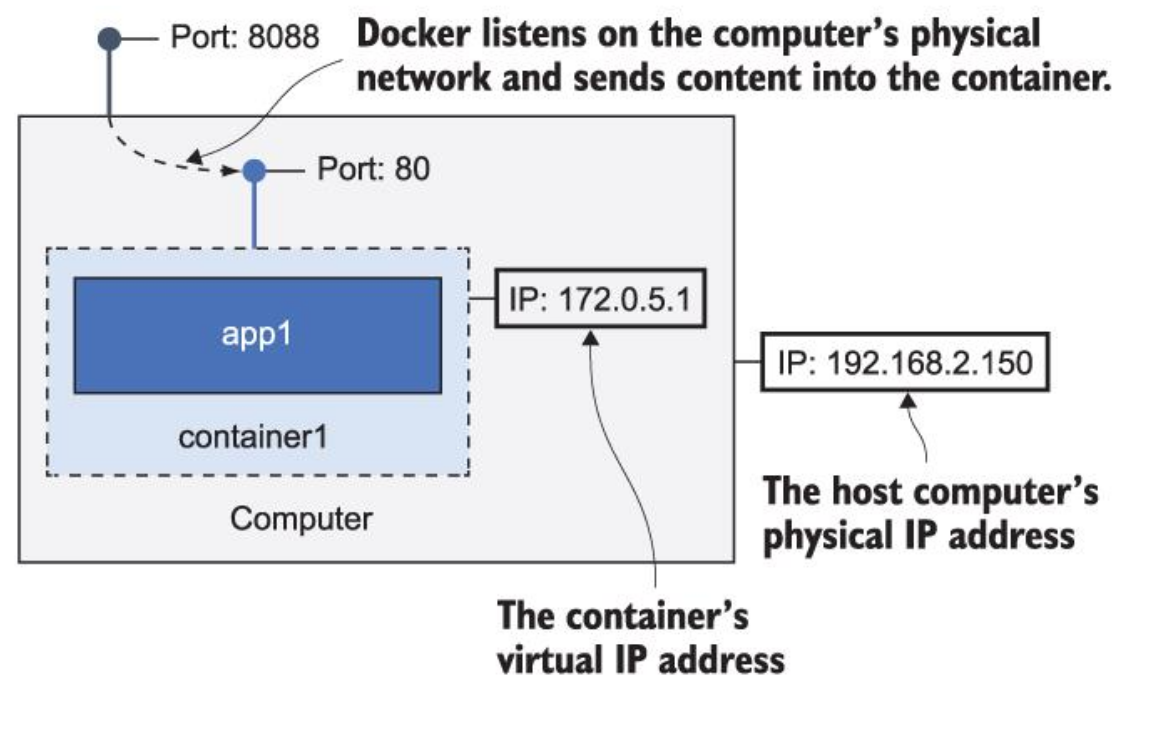

- `docker container rm --force $(docker container ls --all --quiet)`: remove all containers, use with caution since it does not ask for confirmation.

- CLI sends requests to Docker API, which then interacts with the Docker Engine.

- Exercise: replace index.html inside the container to change website front matter. 
    - Used `docker container` to find `cp` from among the available commands.
    - Used `docker exec jovial_meninsky ls -R` to list container's file system info.
    - Had to find absolute path since relative paths would not work -> `docker exec jovial_meninsky pwd` for path prefix
    - Solution:  `docker container cp diamol/ch02/exercises/hello-diamol-web/html/index.html jovial_meninsky:/usr/local/apache2/htdocs/index.html`
Successfully copied 2.05kB to jovial_meninsky:/usr/local/apache2/htdocs/index.html

### Ch. 3: Building your own docker images with Dockerfile

- `docker container run` will download image locally if it's not on the machine because software distribution is built into the Docker platform.  Or can use `docker image pull`.
- Docker images may be packaged with default set of config values, but you should be able to provide different config settings when running a container (using environment variables for example, which are just key/value pairs provided by the operating system). For example, replace TARGET environment variable with google.com below:
    - docker container run --env TARGET=google.com diamol/ch03-web-ping
- From a directory containing a Dockerfile, build an image with current directory as context via:
    - `docker image build --tag web-ping .`
- Process for running apps with Docker:
    - Write Dockerfile with steps to package the app
    - Collect the resources that need to go into Docker image
    - Decide how you want users of image to configure app behavior
    


- Image layers can be shared between different images and different containers.
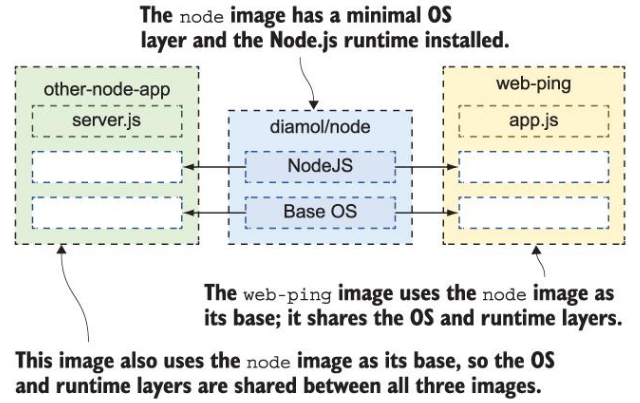

- Notice how each gcr and mintonano image are listed at 17.4GB yet `docker system df` lists total usage at less than 18GB: This is because the layers between these two large images are shared!

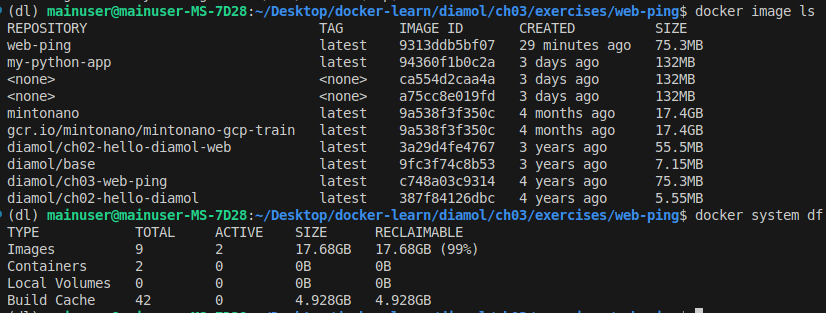

- Because image layers can be shared, they can't be edited (read-only).
- If contents/commands of a given step change, the following steps will be re-executed; previous layers are used from cache.  Docker knows that previous layers didn't change because their hash hasn't changed (hash is made from instructions and files being copied).
- Optimize the file by moving parts unlikely to change towards the top and combining commands:

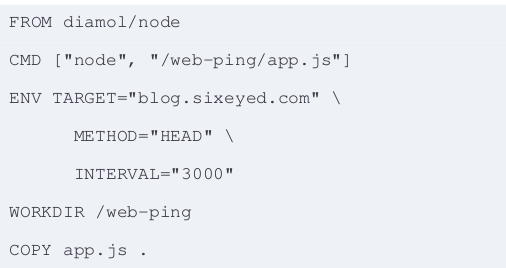

- Lab 3: Modifying contents of Docker container without modifying Dockerfile.
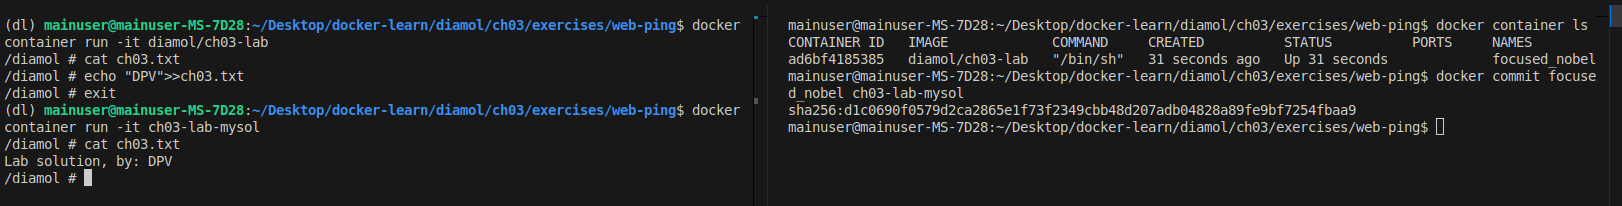

- Note that I ran `docker commit` while the diamol/ch03-lab was running, before typing exit.  Then can go to the newly created container that now has new contents.

### Ch. 4: Packaging applications from source code into Docker images

In the provided Dockerfile, the build tools and dependencies are excluded from the final image by using a multi-stage build. Here’s how it works step-by-step:

### Multi-Stage Build Explanation

1. Builder Stage:
    ```Dockerfile
    FROM diamol/maven AS builder

    WORKDIR /usr/src/iotd
    COPY pom.xml .
    RUN mvn -B dependency:go-offline

    COPY . .
    RUN mvn package
    ```
    - Base Image: `diamol/maven` is used as the base image, which includes Maven and all necessary build tools.
    - Working Directory: Sets the working directory to `/usr/src/iotd`.
    - Copy `pom.xml`: Copies the `pom.xml` file to the container.
    - Download Dependencies: Runs `mvn -B dependency:go-offline` to download all dependencies specified in the `pom.xml` file.
    - Copy Source Code: Copies the entire source code to the container.
    - Build the Project: Runs `mvn package` to compile the source code and package it into a JAR file.

2. Application Stage:
    ```Dockerfile
    FROM diamol/openjdk

    WORKDIR /app
    COPY --from=builder /usr/src/iotd/target/iotd-service-0.1.0.jar .

    EXPOSE 80
    ENTRYPOINT ["java", "-jar", "/app/iotd-service-0.1.0.jar"]
    ```
    - Base Image: `diamol/openjdk` is used as the base image, which includes only the JDK runtime environment.
    - Working Directory: Sets the working directory to `/app`.
    - Copy JAR File: Copies the JAR file from the `builder` stage to the `/app` directory in the application stage using `COPY --from=builder`.
    - Expose Port: Informs Docker that the container will listen on port 80.
    - Set Entry Point: Sets the command to run the JAR file using `java -jar`.

### How Build Tools and Dependencies are Excluded

- Builder Stage: The `builder` stage uses the `diamol/maven` image, which includes Maven and all necessary build tools to compile the Java application. This stage performs all the build-related tasks, such as downloading dependencies and packaging the application into a JAR file.
- Application Stage: The `app` stage uses the `diamol/openjdk` image, which only includes the JDK runtime environment. It does not include Maven or any other build tools.
  - The `COPY --from=builder` command copies only the compiled JAR file from the `builder` stage to the `app` stage. This means that none of the build tools, source code, or dependencies downloaded during the build process are included in the final image.
  - As a result, the final image is smaller and only contains the runtime environment and the packaged application, making it more efficient and secure.

By using multi-stage builds, you ensure that the final Docker image contains only what is necessary to run the application, excluding all build tools and intermediate files used during the build process.

- `docker network create nat`: creates a Docker network, allowing any containers on the network to reach each other using the container names via a bridge network.  Else containers can communicate via host's networking space.
- To run, use  `docker run --name iotd -p 800:80 --network nat image-of-the-day`.  Will run NASA's image of the day REST API so you can make repeated calls to this application without hitting NASA's service.

#### Example in interpreted application
- Let's break down the purpose of the final `WORKDIR` and `COPY` commands in the context of the provided Dockerfile:

```Dockerfile
FROM diamol/node AS builder

WORKDIR /src
COPY src/package.json .
RUN npm install

# app
FROM diamol/node

EXPOSE 80
CMD ["node", "server.js"]

WORKDIR /app
COPY --from=builder /src/node_modules/ /app/node_modules/
```
### Application Stage

#### FROM diamol/node

```Dockerfile
FROM diamol/node
```
- Purpose: Uses the `diamol/node` image as the base image for the application stage.
- Effect: This stage will be used to run the application.

#### EXPOSE 80

```Dockerfile
EXPOSE 80
```
- Purpose: Informs Docker that the container will listen on port 80 at runtime.
- Effect: This is a documentation feature and does not actually publish the port.

#### CMD ["node", "server.js"]

```Dockerfile
CMD ["node", "server.js"]
```
- Purpose: Sets the default command to run when the container starts.
- Effect: The container will run `node server.js` when it starts.

#### WORKDIR /app

```Dockerfile
WORKDIR /app
```
- Purpose: Sets the working directory to `/app` for subsequent instructions in the application stage.
- Effect: Any relative paths in subsequent commands will be relative to `/app`.

#### COPY --from=builder /src/node_modules/ /app/node_modules/

```Dockerfile
COPY --from=builder /src/node_modules/ /app/node_modules/
```
- Purpose: Copies the `node_modules` directory from the `builder` stage to the `/app` directory in the application stage.
- Effect: This ensures that the application has access to the installed dependencies without including the entire build context.

### Summary

- WORKDIR /app: Sets the working directory to `/app` for subsequent instructions. This helps in organizing the application files within the container.
- COPY --from=builder /src/node_modules/ /app/node_modules/: Copies the `node_modules` directory from the `builder` stage to the `/app` directory in the final image. This ensures that the final image contains the necessary runtime dependencies without including the entire build context.

By using these commands, the Dockerfile ensures that the final image is clean and contains only the necessary files to run the application, while keeping the build process and dependencies separate.

- Example of 'refactoring' Dockerfile from ~500MB -> ~17MB on Linux.

In [ ]:
FROM diamol/golang 

WORKDIR web
COPY index.html .
COPY main.go .

RUN go build -o /web/server
RUN chmod +x /web/server

CMD ["/web/server"]
ENV USER=sixeyed
EXPOSE 80

- The image built with this file includes the go compiler and other unnecessary build tools.  In addition, any time we change index.html or anything prior to the RUN commands, the entire application will be rebuilt since RUN commands are in layers following these changes.  The final-stage second image will not contain the build tools and if we change index.html, only the final layer will be rebuilt since others will come from cache.

In [ ]:
FROM diamol/golang AS builder

COPY main.go .
RUN go build -o /server
RUN chmod +x /server

# app
FROM diamol/base

EXPOSE 80
CMD ["/web/server"]
ENV USER="sixeyed"

WORKDIR web
COPY --from=builder /server .
COPY index.html .

### Ch. 5: Sharing images with Docker Hub and other registries

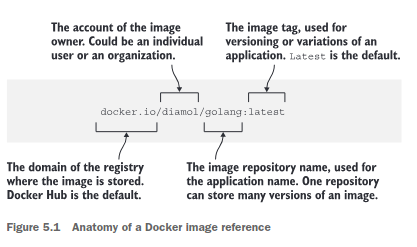

- Pushing images to Docker Hub:
    - Set dockerId environment variable: `export dockerId="my-docker-id"` (used to log in to Docker Hub)
    - `docker login --username $dockerId`
    - `docker image tag image-gallery $dockerId/image-gallery:v1` (note that tagging an image built locally will not rebuild the image, will just make another reference to the same image)
    - `docker image push $dockerId/image-gallery:v1`
- Note that free version of Docker Hub only supports public repositories.


### Other Notes

- Restarting docker service installed with snap:

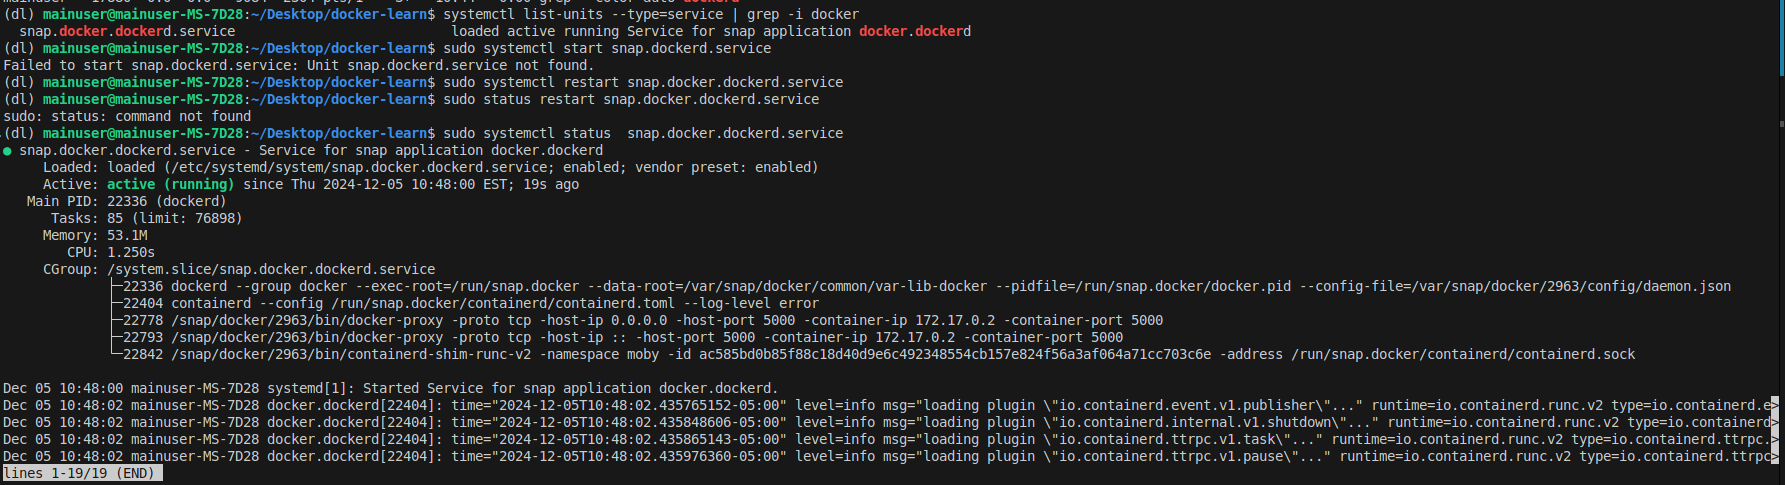

#### Docker under the hood: containerd -> Kernel (Namespaces, Cgroups, system processes)

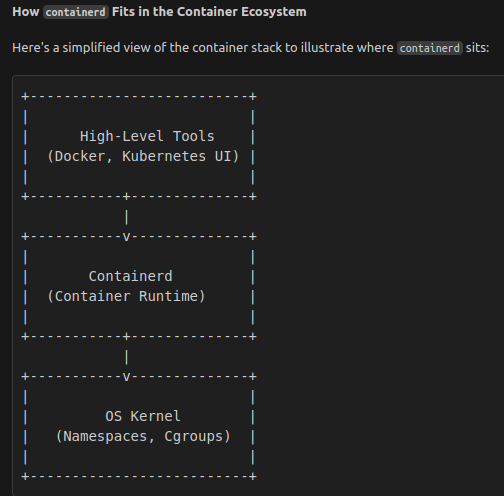

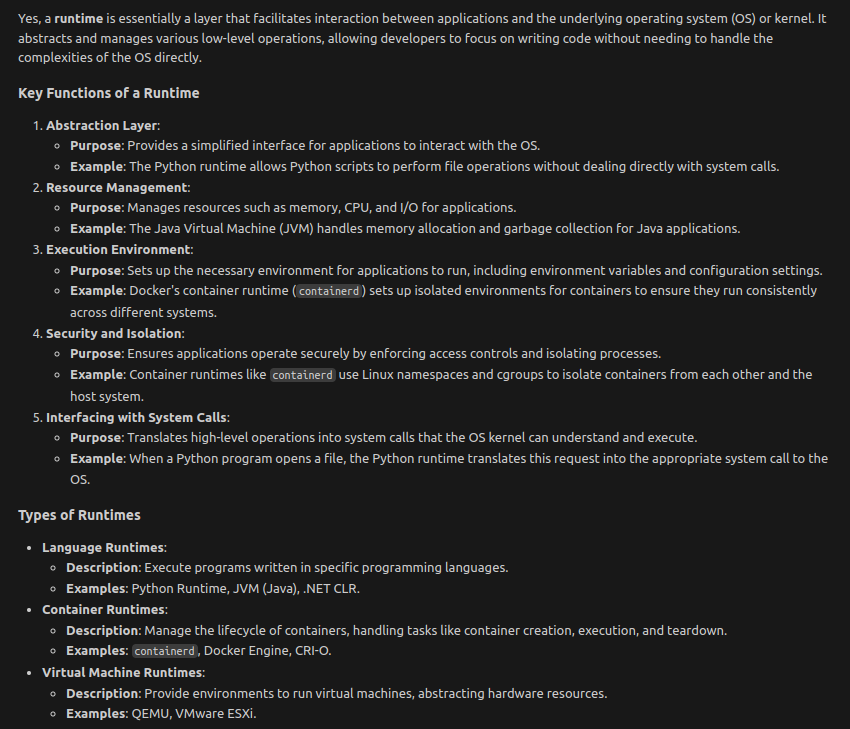

### Understanding Namespaces and cgroups in `containerd`

`containerd` leverages Linux kernel features, specifically Namespaces and cgroups (control groups), to provide container isolation and resource management. These technologies are fundamental to how containers operate securely and efficiently on a host system.

---

#### 1. Namespaces

Namespaces provide isolation for various system resources, ensuring that processes within a container are separated from those in other containers and the host system. Each namespace type isolates a specific resource.

##### Types of Namespaces Used by `containerd`:

| Namespace Type | Description                                                                                     |
|--------------------|-----------------------------------------------------------------------------------------------------|
| PID Namespace  | Isolates the process IDs, so processes inside the container cannot see or interact with processes outside. |
| NET Namespace  | Isolates networking resources like network interfaces, IP addresses, and routing tables.             |
| IPC Namespace  | Isolates inter-process communication resources, such as shared memory and semaphores.               |
| UTS Namespace  | Isolates hostname and domain name settings, allowing containers to have their own hostname.         |
| MNT Namespace  | Isolates mount points, ensuring the container has its own filesystem hierarchy.                      |
| USER Namespace | Isolates user and group IDs, allowing containers to have a different set of user privileges.          |

##### How `containerd` Uses Namespaces:

- Process Isolation: Ensures that container processes run independently without interfering with host or other container processes.
- Network Isolation: Allows containers to have separate networking stacks, enabling features like port mapping and virtual networks.
- Filesystem Isolation: Provides containers with their own root filesystem, preventing unauthorized access to the host filesystem.
- Security: Enhances security by limiting the visibility and accessibility of system resources to containers.

##### Example: PID Namespace Isolation

```sh
# On the host
ps aux

# Inside a container
ps aux
# The container only sees its own processes, not those on the host.
```

---

#### 2. cgroups (Control Groups)

cgroups manage and limit the resources (CPU, memory, disk I/O, network) that containers can consume. They ensure that containers operate within defined resource boundaries, preventing any single container from monopolizing system resources.

##### Key Features of cgroups:

| Feature            | Description                                                                                     |
|------------------------|-----------------------------------------------------------------------------------------------------|
| Resource Limiting  | Sets maximum resource usage (e.g., CPU shares, memory limits) for containers.                      |
| Prioritization     | Allocates resources based on priority, ensuring critical containers receive necessary resources.     |
| Accounting         | Monitors and tracks resource usage by containers for reporting and analysis.                        |
| Control            | Provides mechanisms to freeze, resume, or modify resource allocations of running containers.        |

##### How `containerd` Uses cgroups:

- Resource Allocation: Defines limits on CPU, memory, and other resources for each container to ensure fair distribution.
- Performance Management: Prevents resource overuse by containers, maintaining overall system stability and performance.
- Scalability: Enables efficient scaling of containers by managing resource distribution dynamically based on container demands.

##### Example: Memory Limiting with cgroups

```sh
# Define a memory limit for a container
docker run -d --name limited-container --memory="256m" nginx

# Verify the memory limit using cgroups
cat /sys/fs/cgroup/memory/docker/<container-id>/memory.limit_in_bytes
# Output: 268435456 (256MB)
```

---

#### 3. Integration of Namespaces and cgroups in `containerd`

`containerd` orchestrates the creation and management of both Namespaces and cgroups to ensure containers are isolated and resource-constrained appropriately.

##### Workflow Overview:

1. Container Creation:
   - `containerd` initiates the creation of a container using the specified image.
   
2. Namespace Setup:
   - Allocates and configures appropriate namespaces to isolate the container's environment.

3. cgroups Configuration:
   - Assigns the container to specific cgroups with defined resource limits.

4. Process Execution:
   - Launches the container's main process within the isolated namespaces and under the resource constraints of the cgroups.

5. Monitoring and Management:
   - Continuously monitors resource usage and enforces cgroup limits.
   - Manages the lifecycle of the container, including starting, stopping, and deletion.


#### 4. Benefits of Using Namespaces and cgroups with `containerd`

- Isolation: Ensures containers run securely and independently without affecting each other or the host system.
- Resource Efficiency: Optimizes resource usage by enforcing limits and preventing overconsumption.
- Scalability: Facilitates the deployment of multiple containers on a single host by managing resource distribution effectively.
- Security: Enhances security by restricting containers' access to system resources and isolating their environments.
- Performance: Maintains system stability and performance by preventing resource contention among containers.

---
### Summary

- Namespaces: Provide isolation for container processes by segregating various system resources, ensuring containers operate independently and securely.
- cgroups: Manage and limit resource usage for containers, maintaining system stability and efficient resource distribution.
- `containerd`: Utilizes both Namespaces and cgroups to orchestrate container lifecycles, ensuring isolation, security, and resource management.


## Resolving issues

- On
docker push us-central1-docker.pkg.dev/aitutor-447020/aitutor-repo/aitutor:latest
  - Kept getting
    - unauthorized: authentication failed

- Solved via:
    - TOKEN=$(gcloud auth print-access-token)
    - echo $TOKEN | docker login -u oauth2accesstoken --password-stdin https://us-central1-docker.pkg.dev
